To start the Stanford CoreNLP server (which is necessary to run this code), run the following commands in the terminal:
<pre><code>$ export PATH=~/jdk1.8.0_251/bin:$PATH
$ cd ~/mitx-utilities/surveys/stanford-corenlp-full-2018-10-05
$ java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -annotators "tokenize,ssplit,pos,lemma,parse" -port 9000 -timeout 30000
</code></pre>

Might need to change the second line to 
<pre><code> $ cd /yw_data/alexander_shashkov/mitx-utilities/surveys/stanford-corenlp-full-2018-10-05 </code></pre>
if you access from different home directory.

In [6]:
#no idea why this doesn't work, it isn't switching into the correct directory for some reason
#works just fine in terminal
!export PATH=~/jdk1.8.0_251/bin:$PATH
!cd /yw_data/alexander_shashkov/mitx-utilities/surveys/stanford-corenlp-full-2018-10-05
!java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -annotators "tokenize,ssplit,pos,lemma,parse" -port 9000 -timeout 30000

Error: Could not find or load main class edu.stanford.nlp.pipeline.StanfordCoreNLPServer


In [7]:
import nltk
import re
from pycorenlp import StanfordCoreNLP
import matplotlib
import pickle
nlp=StanfordCoreNLP("http://localhost:9000/")

from preprocess import *
from utilities import *
from constants import *
from supervised_sentiment_analysis import *
from graphing import *


sent = "The problem was fairly straightforward, taking into account the work already done in problems 1 & 2, and the finger exercises using bisection search.  The one thing that could have tripped me up was what test to use for when arrived at answer.  At first I thought >0 and <0, then realized that it would try to get exact to many decimals, which was unnecessary and might be impossible.  So, used a comparison of > 0.01 < -0.01."

In [8]:
sent = "The problem was fairly straightforward, taking into account the work already done in problems 1 & 2, and the finger exercises using bisection search.  The one thing that could have tripped me up was what test to use for when arrived at answer.  At first I thought >0 and <0, then realized that it would try to get exact to many decimals, which was unnecessary and might be impossible.  So, used a comparison of > 0.01 < -0.01."

- returns the high level verb phrases within a sentence
- these are supposed to represent "steps" within the student's procedure
- a phrase is added if it:
    - is not part of another verb phrase
    - does not contain any conjunctions
- this is a pretty arbitrary criteria but it work pretty well

In [9]:
def get_verb_phrases(sentences):
    # get parse trees of inputted sentences
    parser = nlp.annotate(sentences, properties={"annotators":"parse","outputFormat": "json"})
    sent_trees = [nltk.tree.ParentedTree.fromstring(parser["sentences"][k]["parse"]) for k in range(len(parser['sentences']))]
    
    # loop through the subtrees, adding those representing a verb phrase to sub_trees
    sub_trees = []
    
    for sent_tree in sent_trees:
        for sub_tree in list(sent_tree.subtrees()):

            
            # check if subtree is a verb phrase
            if sub_tree.label() == "VP":
                
                # check if any parents are subtrees
                # TODO: shorten/optimize this
                parent = sub_tree.parent()
                parent_contained = False
                while parent != None:
                    if parent in sub_trees:
                        parent_contained = True
                        break
                    parent = parent.parent()
                if parent_contained:
                    continue
                
                # if verb phrase contains a conjuction, check if the conjuction splits up another verb phrase
                # if it does, skip the verb phrase
                # this is pretty arbitrary but works well in practice
                if "CC" in [leaf[1] for leaf in sub_tree.pos()] and "VP" in [node.label() for node in sub_tree]:
                    continue
                sub_trees.append(sub_tree)
                        
         
    # for each clause level subtree, extract relevant simple sentence and return list of them
    clause_list = []
    for t in sub_trees:
        subject_phrase = ' '.join(t.leaves())
        clause_list.append(subject_phrase)

    return clause_list




In [10]:
sentence = "explain or and operator with boolean true false in a bit more detail"
parser = nlp.annotate(sentence, properties={"annotators":"parse","outputFormat": "json"})
sent_trees = [nltk.tree.ParentedTree.fromstring(parser["sentences"][k]["parse"]) for k in range(len(parser['sentences']))]
[sent_tree.pretty_print() for sent_tree in sent_trees]
print(get_verb_phrases(sentence))

        ROOT                                                                        
         |                                                                           
        UCP                                                                         
    _____|__________                                                                 
   |     |          PP                                                              
   |     |     _____|______                                                          
   |     |    |            NP                                                       
   |     |    |      ______|_________________                                        
   |     |    |     |                        PP                                     
   |     |    |     |       _________________|__________                             
   |     |    |     |      |                            NP                          
   |     |    |     |      |             _______________|___

In [11]:
sent = 'I copied my code from problem 2 as a starting point. I set up the logic for the bisection search such as the low, high, average of the two and the if loops for when it was too high or too low of a guess. After, I used the print and debugging features to figure out what was happening in my code and did find that i was entering an infinite loop since the balance never gets to 0 so i had to do some rounding.'
get_verb_phrases(sent)

['copied my code from problem 2 as a starting point',
 'set up the logic for the bisection search such as the low , high , average of the two and the if loops for when it was too high or too low of a guess',
 'used the print and debugging features to figure out what was happening in my code',
 'did find that i was entering an infinite loop since the balance never gets to 0 so',
 'had to do some rounding']

The first input text is:
> The problem was fairly straightforward, taking into account the work already done in problems 1 & 2, and the finger exercises using bisection search.  The one thing that could have tripped me up was what test to use for when arrived at answer.  At first I thought >0 and <0, then realized that it would try to get exact to many decimals, which was unnecessary and might be impossible.  So, used a comparison of > 0.01 < -0.01.

The second is :
> i went to the store, ran to the mall, debugged and filtered my code, then went to sleep, but couldn't fall asleep

In [12]:
text = "The problem was fairly straightforward, taking into account the work already done in problems 1 & 2, and the finger exercises using bisection search.  The one thing that could have tripped me up was what test to use for when arrived at answer.  At first I thought >0 and <0, then realized that it would try to get exact to many decimals, which was unnecessary and might be impossible.  So, used a comparison of > 0.01 < -0.01."
print(get_verb_phrases(text))

sent = "i went to the store, ran to the mall, debugged and filtered my code, then went to sleep, but couldn't fall asleep"
print(get_verb_phrases(sent))

['was fairly straightforward , taking into account the work already done in problems 1 & 2', 'using bisection search', 'could have tripped me up', 'was what test to use for when arrived at answer', 'thought > 0 and < 0 , then realized that it would try to get exact to many decimals , which was unnecessary', 'might be impossible', 'used a comparison of > 0.01 <']
['went to the store', 'ran to the mall , debugged and filtered my code', 'then went to sleep', "could n't fall asleep"]


In [13]:
merged_results = pickle.load(open('merged_results.P', 'rb'))
merged_results = get_manual_tags(merged_results, 'manual_tags_Q1.csv')
merged_results = get_manual_tags(merged_results, 'manual_tags_Q2.csv')
q2_results = merged_results[merged_results['Question'] == Q2]
sample = q2_results.sample(n=100, random_state = 1)

In [14]:
results = q2_results
results['index'] = np.arange(len(results))
results = results.set_index('index')
results['Phrase List'] = results['Original'].apply(get_verb_phrases)

/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
from skip_thought_vectors import get_encodings

/yw_data/robert_gold/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/yw_data/robert_gold/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/yw_data/robert_gold/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/yw_data/robert_gold/.local/lib/python3.6/site-packages/tensorflow/

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


INFO:tensorflow:Reading vocabulary from skip-thoughts/skip_thoughts/pretrained/skip_thoughts_uni_2017_02_02/vocab.txt

INFO:tensorflow:Loaded vocabulary with 930914 words.
INFO:tensorflow:Loading embedding matrix from skip-thoughts/skip_thoughts/pretrained/skip_thoughts_uni_2017_02_02/embeddings.npy
INFO:tensorflow:Loaded embedding matrix with shape (930914, 620)
INFO:tensorflow:Building model.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, wh

In [16]:
def encode_phrases(phrase_list):
    if len(phrase_list):
        return get_encodings(phrase_list)
    return []

# TODO: Figure out why .apply doesn't work here
results['Phrase Vectors'] = "A"
count = 0
chunk = max(results.shape[0]//10, 100)
for index, row in results.iterrows():
    phrase_vectors = encode_phrases(row['Phrase List'])
    results.at[index, 'Phrase Vectors'] = phrase_vectors
    if count + 1 % chunk == 0:
        print(f"{count} done out of {results.shape[0]}")
    count += 1
    


In [18]:
all_phrase_vectors = [phrase_vector for phrase_vectors in list(results['Phrase Vectors']) for phrase_vector in phrase_vectors]

len(all_phrase_vectors)



3423

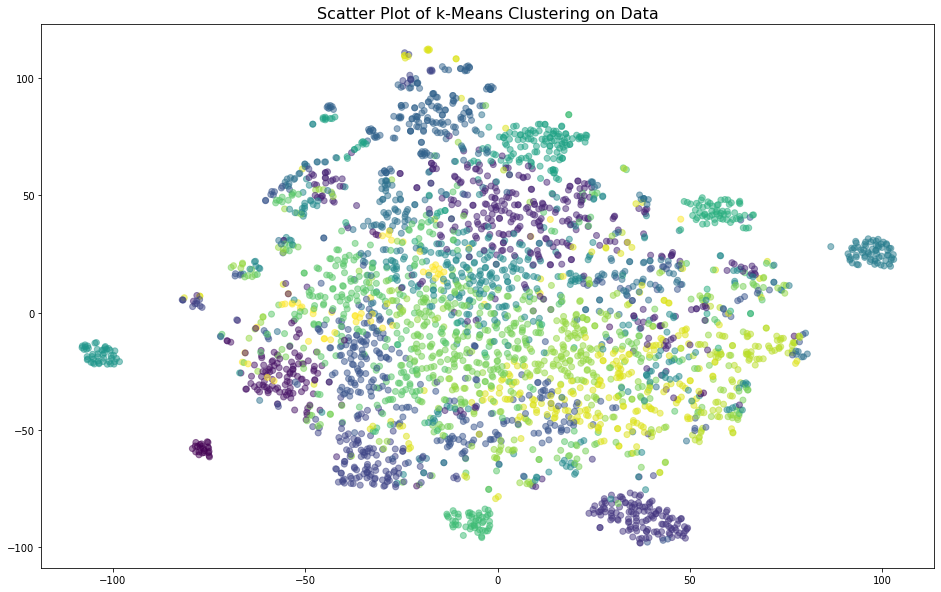

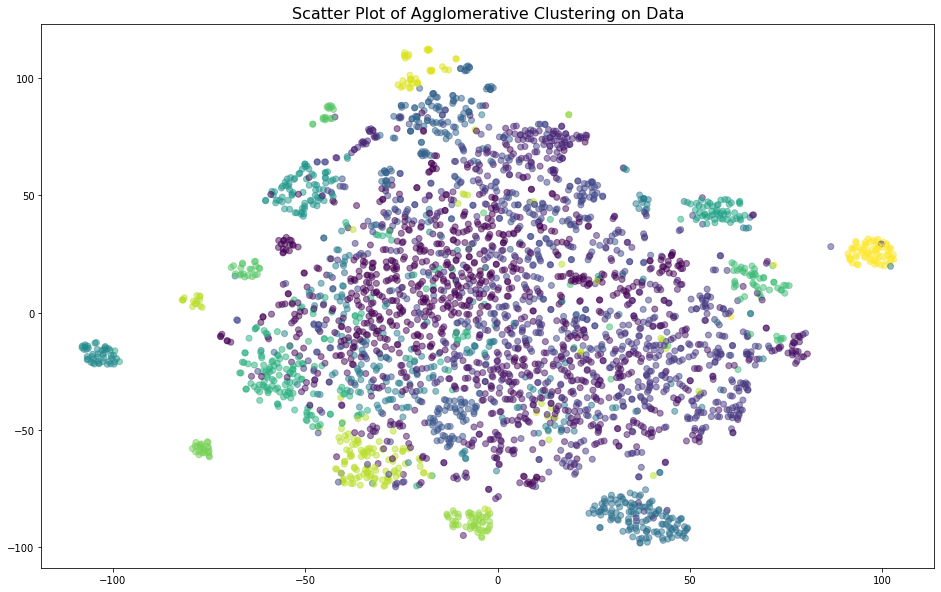

In [19]:
clustering_graphs(all_phrase_vectors, n_clusters = 20)

In [21]:
from sklearn.decomposition import PCA
def reduce_dimensions(X):
    PCA_50 = PCA(n_components=50)
    X_r = PCA_50.fit_transform(X)
    tsne = TSNE(n_components=2, n_iter=5000)
    return tsne.fit_transform(X_r)
tsne_results = reduce_dimensions(all_phrase_vectors)

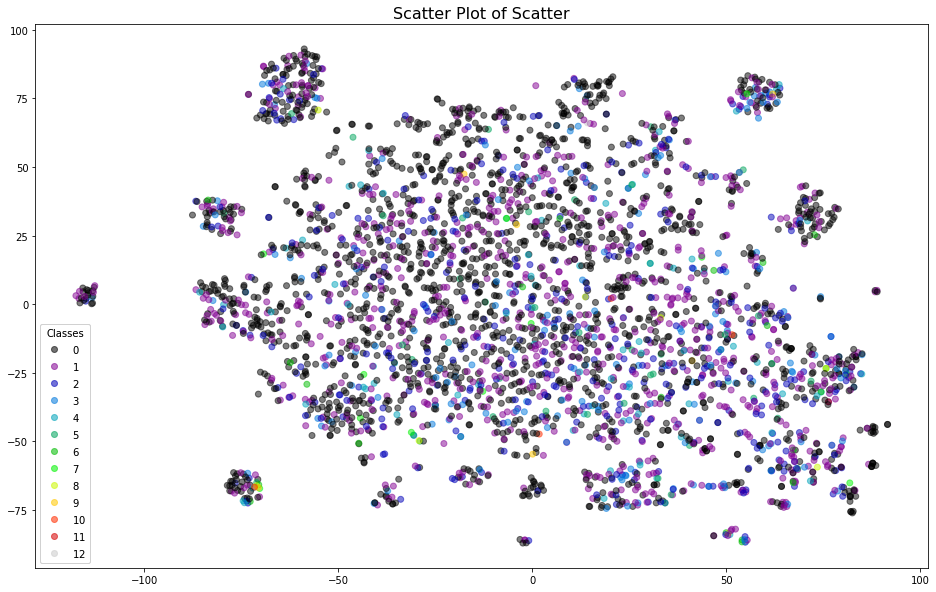

In [22]:
all_phrase_vectors = [phrase_vector for phrase_vectors in list(results['Phrase Vectors']) for phrase_vector in phrase_vectors]
phrase_vector_locs = [k for phrase_vectors in list(results['Phrase Vectors']) for k in range(len(phrase_vectors))]

scatter_plot(tsne_results, labels = phrase_vector_locs, show_legend = True, tsne = False)

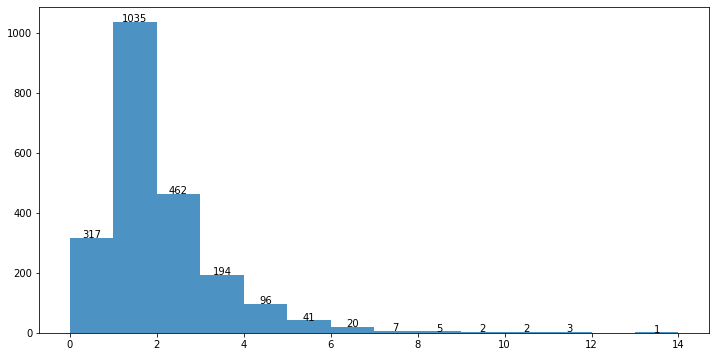

In [23]:
phrase_counts = [len(phrase_vectors) for phrase_vectors in list(results['Phrase Vectors'])]
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
bins = range(max(phrase_counts)+2)
arr = ax.hist(phrase_counts, bins = bins, alpha = 0.8)
bin_width = arr[1][1]-arr[1][0]
for k in bins[:-1]:
    if arr[0][k] > 0:
        plt.text(arr[1][k]+bin_width/2,arr[0][k]+1,str(int(arr[0][k])), ha = 'center')
plt.show()

In [24]:
problem_number = {
    'fex1': 0,
    'ps1': 1,
    'fex2': 2,
    'ps2': 3,
    'fex4': 4,
    'ps4' : 5
    
}
print(results.columns)
problem_numbers = list(results['Problem'].apply(lambda x: problem_number[x]))
flattened_problem_numbers = [problem_numbers[k] for k in range(len(list(results['Phrase Vectors']))) for phrase_vector in list(results['Phrase Vectors'])[k]]
len(flattened_problem_numbers)


Index(['Unnamed: 0', 'username', 'title', 'location', 'Answer', 'Answer ID',
       'Correct Answer', 'Question', 'block_key', 'state', 'Unique ID',
       'Original', 'Manual Tag', 'Problem', 'Categorical Tag',
       'Skip Thought Vector', 'Valid Vector', 'Phrase List', 'Phrase Vectors'],
      dtype='object')


3423

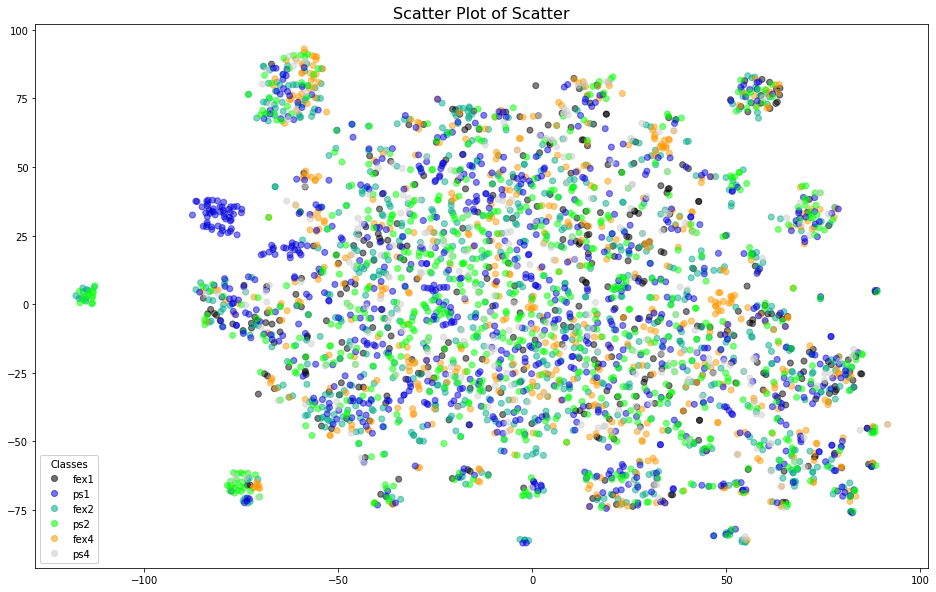

In [25]:
scatter_plot(tsne_results, labels = flattened_problem_numbers, show_legend = True, legend_labels = problem_number.keys(), tsne = False)

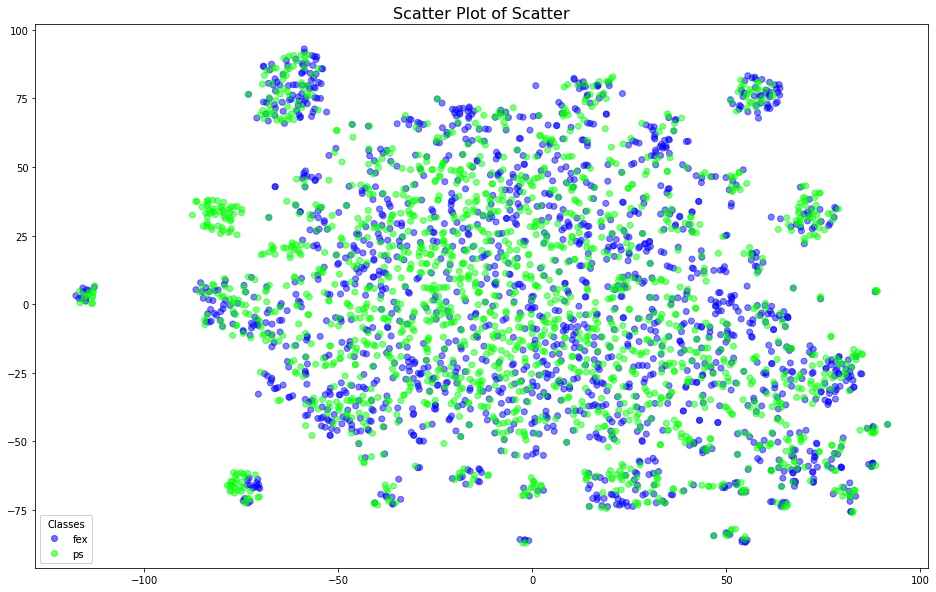

In [26]:
ps_or_fex = [k%2 for k in flattened_problem_numbers]
scatter_plot(tsne_results, labels = ps_or_fex, show_legend = True, legend_labels = ['fex', 'ps'], tsne = False, cmap = plt.cm.brg)

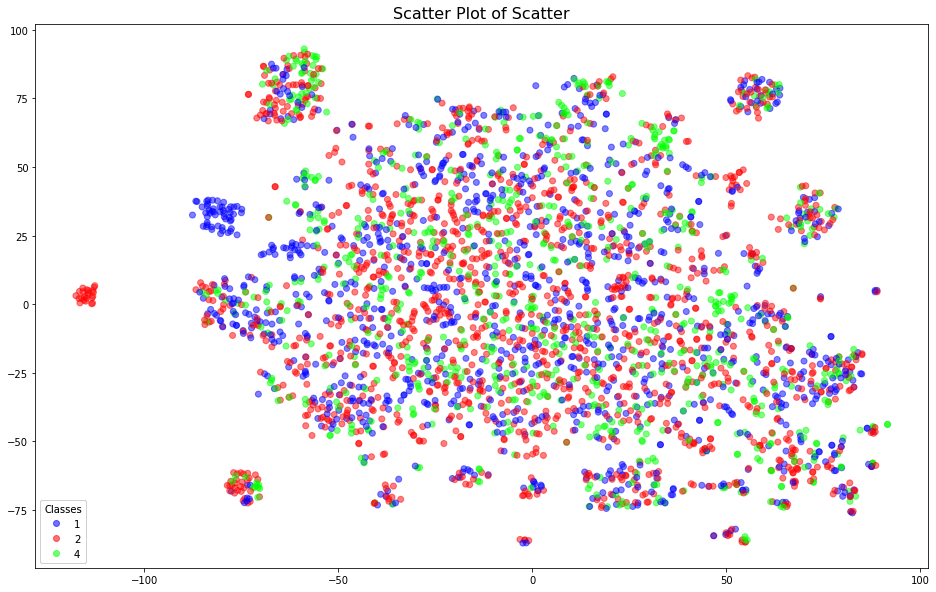

In [27]:
ps_fex_number = [k//2 for k in flattened_problem_numbers]
scatter_plot(tsne_results, labels = ps_fex_number, show_legend = True, legend_labels = ['1', '2', '4'], tsne = False, cmap = plt.cm.brg)

In [28]:
results.columns

Index(['Unnamed: 0', 'username', 'title', 'location', 'Answer', 'Answer ID',
       'Correct Answer', 'Question', 'block_key', 'state', 'Unique ID',
       'Original', 'Manual Tag', 'Problem', 'Categorical Tag',
       'Skip Thought Vector', 'Valid Vector', 'Phrase List', 'Phrase Vectors'],
      dtype='object')

In [29]:
def get_agg_clusters(X, n_clusters=12):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    model.fit(X)
    return model.labels_, model

phrase_results = pd.DataFrame()
phrase_results['phrase vector'] = all_phrase_vectors
phrase_results['phrase'] = all_phrases
phrase_results['Question'] = [row['Question'] for index, row in results.iterrows() for phrase in row['Phrase List']]
labels, model = get_agg_clusters(all_phrase_vectors)
phrase_results['agg cluster'] = labels

In [30]:
phrase_results.shape

(3423, 4)

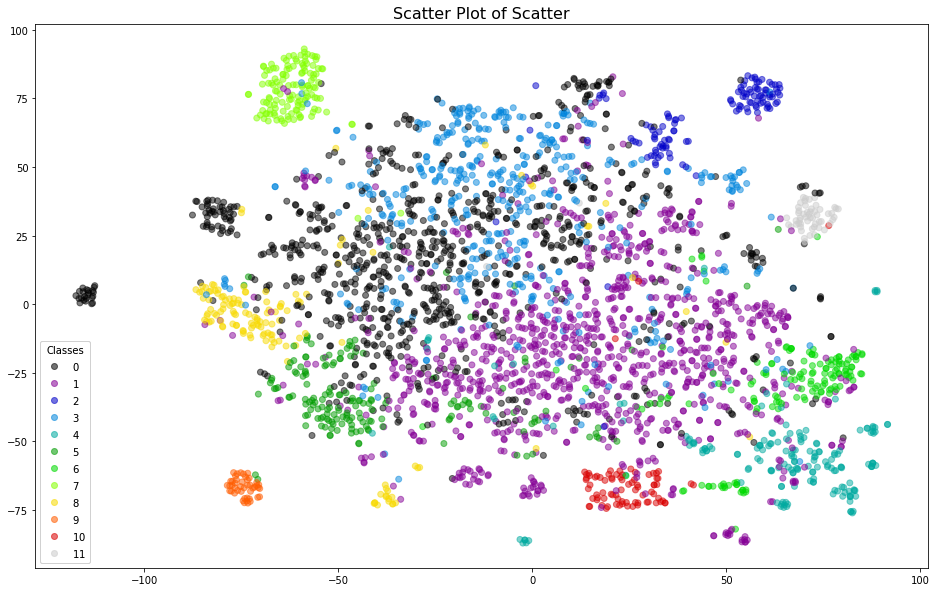

In [32]:
scatter_plot(tsne_results, labels = labels, tsne = False, show_legend = True, cmap = plt.cm.nipy_spectral)